In [29]:
import numpy;
import math;
import matplotlib.pyplot as plt

plot = False
def getData(N, variance):
    """
    Generates a dataset {(xi, yi) : i = 1, 2, . . .N} of N (X, Y ) pairs for a given value of N and sigma^2
    :return: The generated dataset of (X,Y) pairs
    """
    X = numpy.random.rand(N) # N values between 0 and 1
    Z = numpy.random.normal(0, math.sqrt(variance), N) # Zero mean Gaussian random variable, with standard deviation, of length N
    Y = numpy.cos(2*math.pi*X) + Z # Y generated from function (1)

    # store the (X,Y) pairs in a N x 2 matrix
    x_y_pair_matrix = numpy.column_stack((X, Y))
    # optionally plot the dataset that is created
    if plot:
        plt.scatter(X,Y, label="My Random Dataset", marker='x')
        plt.title('Generated Dataset for cos(2*pi*x) from 0 to 1')
    return x_y_pair_matrix

def getMSE(data_set, poly_coefficients):
    X_values = numpy.array(data_set[:, 0]) # Values of x from given dataset
    y_true_values = numpy.array(data_set[:, 1]) # Values of y from given dataset

    # Vandermonde matrix of the function, multiplied by the weights/coefficients gives y_pred
    vander_matrix = numpy.vander(X_values, len(poly_coefficients), True)
    y_pred = vander_matrix.dot(poly_coefficients) 

    # MSE calculation using numpy, but will manually calculate below
    mse = numpy.mean((y_true_values - y_pred)**2) 
    #print ("getMSE_Updated - Auto MSE:", mse)

    # Sum all the squared differences of each y_pred, y_true. Then average that over the vector length, N 
    summation_diffs_squared = 0
    for y_pred_i, y_true_i in zip(y_pred, y_true_values):
        squared_diff = (y_pred_i - y_true_i) ** 2
        summation_diffs_squared += squared_diff
    mse = summation_diffs_squared / len(y_true_values)
    #print ("getMSE_Updated - Manual MSE: ", mse)
    return mse

def fitData(data_set, degree_poly, test_dataset, is_reg):
    """
    fitData method that estimates the polynomial coefficients by fitting a given data to a degree-d polynomial
    :return: estimated_coefficients, Ein (MSE), Eout
    """
    # Hyperparameters of GD
    learning_rate = 0.01
    weight_decay_regularization = 0.1
    iterations = 2000

    X_values = numpy.array(data_set[:, 0]) # Values of x from given dataset, vector is 1xN
    Y_values = numpy.array(data_set[:, 1]) # Values of y from given dataset, vector is 1xN
    N = len(Y_values)

    # Random starting coefficents
    weights = numpy.random.rand(degree_poly+1) # vector is 1x(D+1)
    # Vandermonde matrix, for all X values, without coefficients of N X (D+1) size
    vander_matrix = numpy.vander(X_values, degree_poly+1, True)

    Y_pred = vander_matrix.dot(weights)
    for x in range(iterations):
        Y_pred = vander_matrix.dot(weights)

        # If regularization is set, ensure the weight decary regularization term is added to the gradient. If not, exclude it
        if is_reg:
            gradient = -2*(learning_rate/N) * ((Y_values - Y_pred)).dot(vander_matrix) + weight_decay_regularization*learning_rate*weights
        else:
            gradient = -2*(learning_rate/N) * ((Y_values - Y_pred)).dot(vander_matrix)
        
        weights -= gradient

    if plot:
        plt.scatter(X_values,Y_pred, label="My Random Dataset", marker='o')
        plt.title('Predicted Y Values')

    Ein = getMSE(data_set, weights)
    Eout = getMSE(test_dataset, weights)
    return weights, Ein, Eout # this should be changed to the eventual estimated coefficients

def experiment(N, d, variance, is_reg):
    """
    Takes as input the size N of training dataset, the degree d of the model polynomial and noise variance σ^2.
    For given values, loops over M=50 trials, where each trial generates a dataset of size N with variance, σ^2, 
    and then fitting the data to a polynomial of degree d.

    :return: Output the average Ein_bar, Eout_bar which is the average Ein and Eout over M trials run after fitting the polynomial to the data
    """
    Ein_array = []
    Eout_array = []
    M = 50

    for i in range(M):
        training_dataset = getData(N, variance)
        test_dataset = getData(2000, variance)
        coeff,Ein_i,Eout_i = fitData(training_dataset, d, test_dataset, is_reg)
        Ein_array.append(Ein_i)
        Eout_array.append(Eout_i)

    Ein_bar = numpy.mean(Ein_array)
    Eout_bar = numpy.mean(Eout_array)
    return Ein_bar, Eout_bar

In [30]:
### Run the experiments

N_values = [2, 5, 10, 20, 50, 100, 200]
d_values = [1, 2, 4, 8, 16, 32, 64]

# Create a tuple with all values for each variance setting so they can be filtered later: (N, d, Ein_bar, Eout_bar)
output_variance_zeropoint5 = []
output_variance_point2 = []

# Test runs for variance at 0.05, with no regularization
for N in N_values:
    for d in d_values:
        Ein_bar, Eout_bar = experiment(N, d, 0.05, False)
        output_variance_zeropoint5.append((N, d, Ein_bar, Eout_bar))

# Test runs for variance at 0.2, with no regularization
for N in N_values:
    for d in d_values:
        Ein_bar, Eout_bar = experiment(N, d, 0.2, False)
        output_variance_point2.append((N, d, Ein_bar, Eout_bar))

N=20: (0.4799594417574198, 0.4091981430879779, 0.24671093304558014, 0.21261141989422971, 0.2084720513564356, 0.22435929237167124, 0.2111291672721231)
N=50: (0.5280227332286733, 0.43773125042376804, 0.26033755095843597, 0.22366786937013006, 0.2513741147840643, 0.22743022150103587, 0.23697755347099086)
N=200: (0.5488123644395211, 0.4422163017844655, 0.27553614745686134, 0.2362732745420826, 0.25731217688360497, 0.23611453719032138, 0.22560535923191324)


<function matplotlib.pyplot.show(close=None, block=None)>

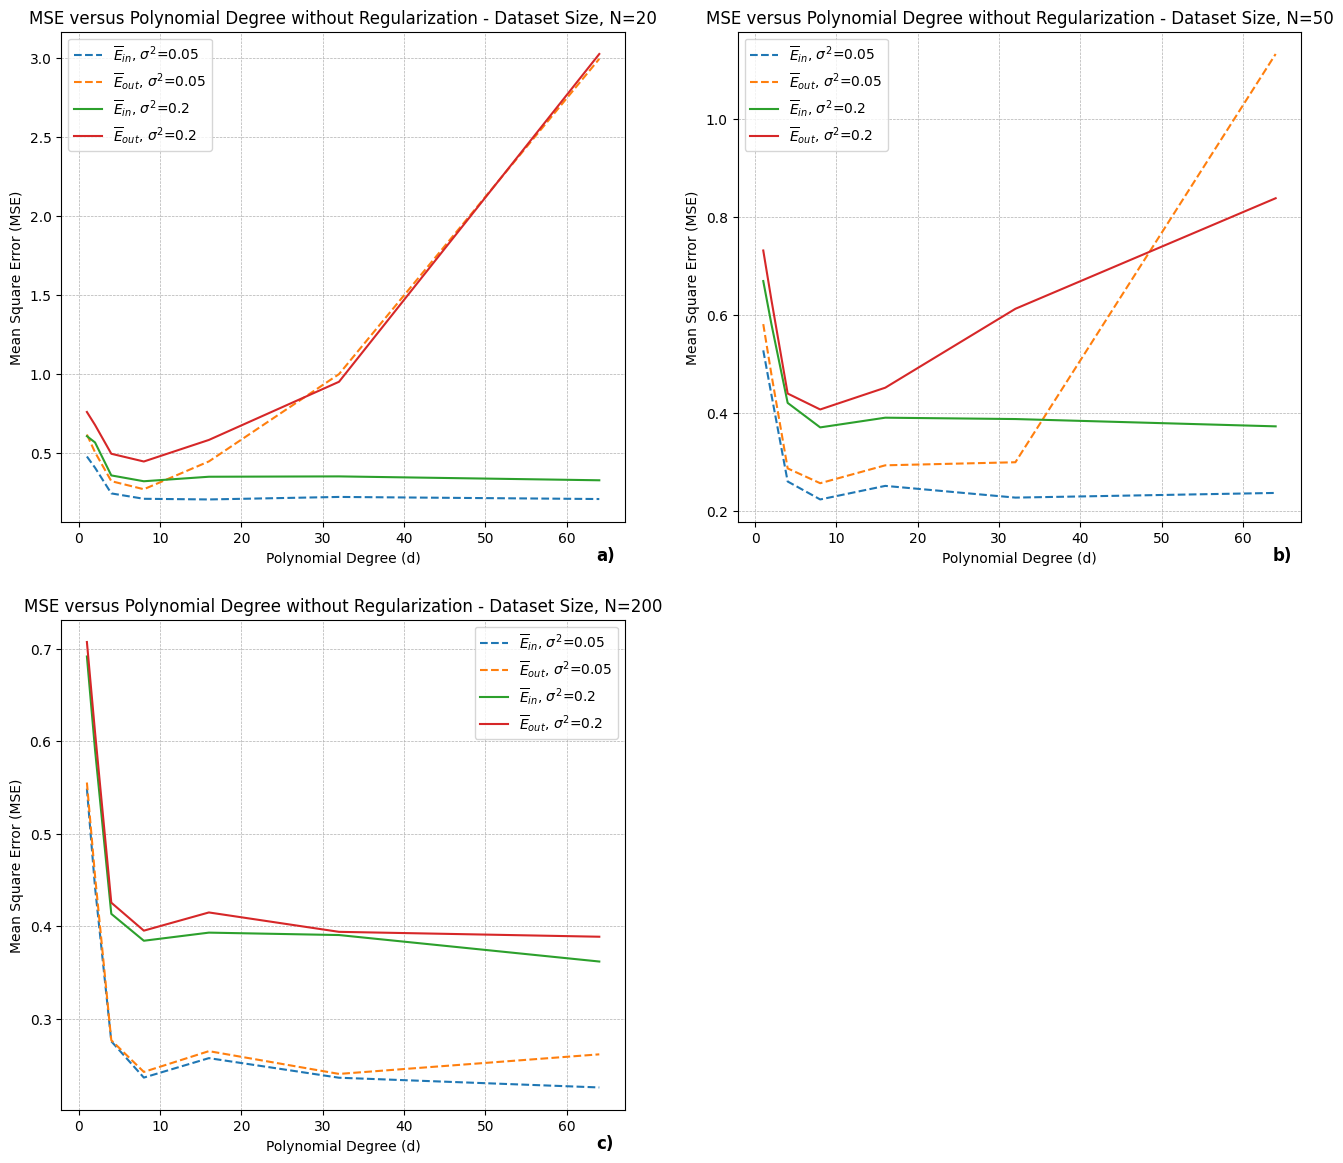

In [31]:
# Variables for overline and subscripts used in graphs
e_hat = r'$\overline{E}$'
in_sub = r'$_{in}$'
out_sub = r'$_{out}$'

# Plot graphs for fixed values of N without regularization
# Reminder: Output tuples have format - (N, d, Ein_bar, Eout_bar)
N_array_mapping = [20, 50, 200]
# Add labels to the subplots
labels = ['a)', 'b)', 'c)', 'd)']  # You can customize the labels as needed

current_subplot = 1
plt.figure(figsize=(16, 14))
for N_value in N_array_mapping:
    # Filter the list of result tuples to only return was the first element of the tuple, N, equals the chosed N value
    results_N_10_zeropoint5 = list(filter(lambda output_tuple: output_tuple[0] == N_value, output_variance_zeropoint5))
    results_N_10_point2 = list(filter(lambda output_tuple: output_tuple[0] == N_value, output_variance_point2))

    d_array = list(zip(*results_N_10_zeropoint5))[1]
    E_in_zeropoint5 = list(zip(*results_N_10_zeropoint5))[2]
    E_out_zeropoint5 = list(zip(*results_N_10_zeropoint5))[3]
    E_in_point2 = list(zip(*results_N_10_point2))[2]
    E_out_point2 = list(zip(*results_N_10_point2))[3]

    print(f"N={N_value}:", E_in_zeropoint5)

    # Add this subplot to the figure of all graphs
    axs = plt.subplot(2,2,current_subplot)
    plt.plot(d_array, E_in_zeropoint5, label=f"{e_hat}{in_sub}, $\sigma^2$=0.05",linestyle='--')
    plt.plot(d_array, E_out_zeropoint5, label=f"{e_hat}{out_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(d_array, E_in_point2, label=f"{e_hat}{in_sub}, $\sigma^2$=0.2")
    plt.plot(d_array, E_out_point2, label=f"{e_hat}{out_sub}, $\sigma^2$=0.2")
    plt.xlabel("Polynomial Degree (d)")
    plt.ylabel("Mean Square Error (MSE)")
    plt.title(f"MSE versus Polynomial Degree without Regularization - Dataset Size, N={N_value}")
    plt.legend(fontsize=10)
    plt.grid(linewidth=0.5, linestyle='--')
    axs.text(0.95, -0.05, labels[current_subplot-1], transform=axs.transAxes, fontsize=12, weight='bold', va='top')
    current_subplot += 1
    
plt.show

N=200: (0.03067686974806056, 0.24735446523324164, 0.3497364513102794, 0.4091981430879779, 0.43773125042376804, 0.45256274490904375, 0.4422163017844655)
N=200: (0.028857075207661374, 0.12740015982102043, 0.1934852051682336, 0.2084720513564356, 0.2513741147840643, 0.2541833534345427, 0.25731217688360497)
N=200: (0.013870131670758366, 0.1280926109392194, 0.17057836108615188, 0.22435929237167124, 0.22743022150103587, 0.22966055972425875, 0.23611453719032138)


<function matplotlib.pyplot.show(close=None, block=None)>

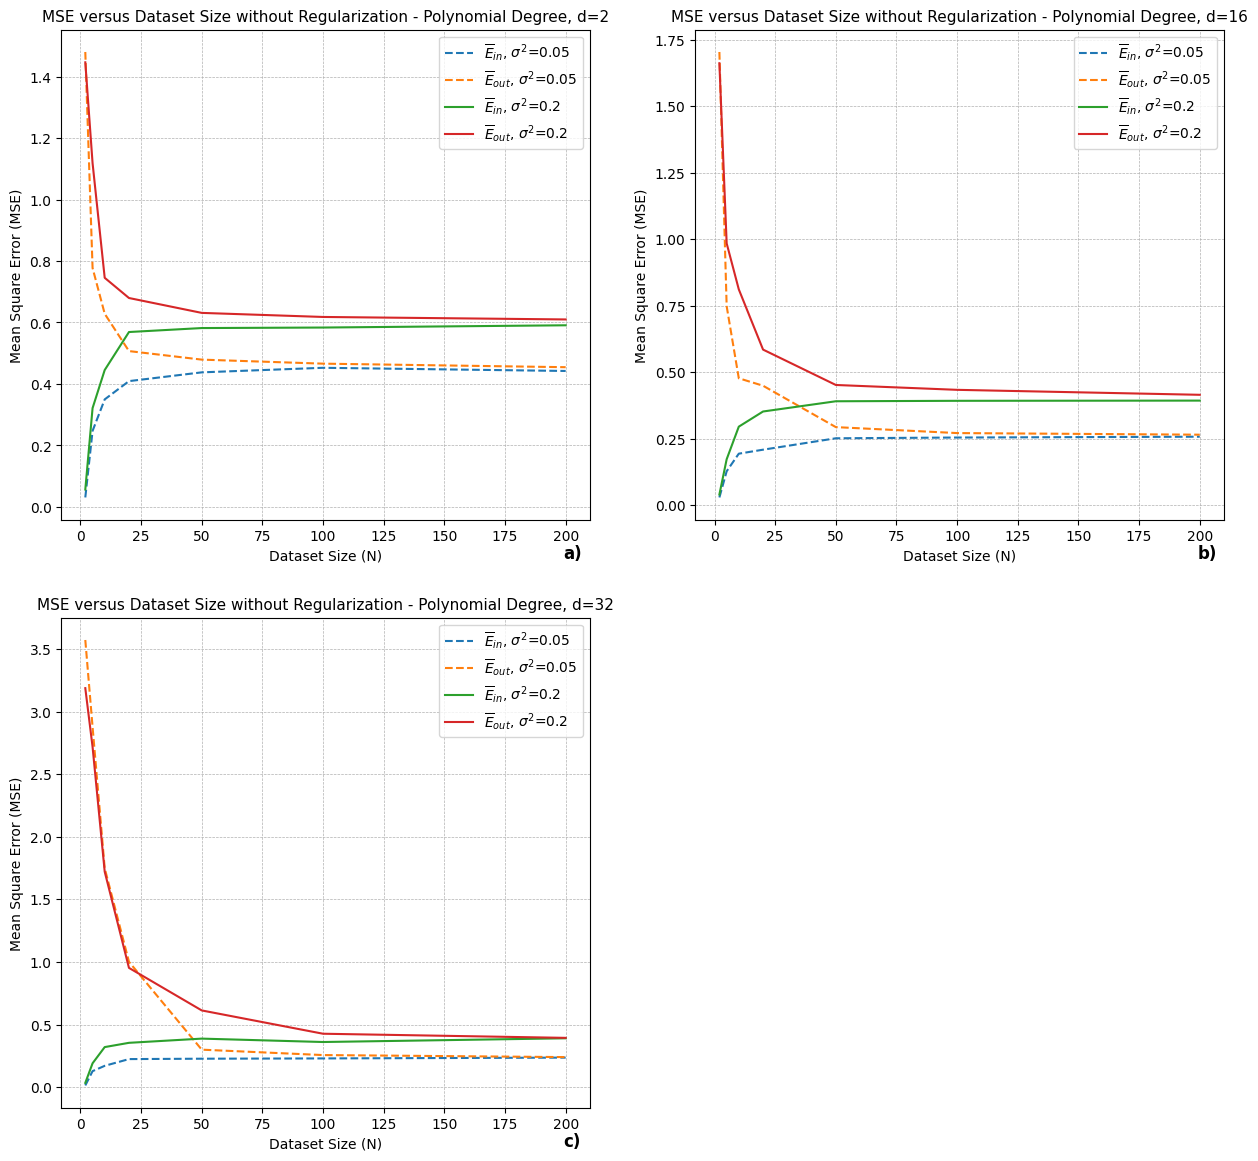

In [32]:
# Plot graphs for fixed values of d without regularization
# Reminder: Output tuples have format - (N, d, Ein_bar, Eout_bar)
d_array_mapping = [2,16,32]
current_subplot = 1
plt.figure(figsize=(15, 14))
for d_value in d_array_mapping:
    # Filter the list of result tuples to only return was the first element of the tuple, N, equals the chosed N value
    results_N_10_zeropoint5 = list(filter(lambda output_tuple: output_tuple[1] == d_value, output_variance_zeropoint5))
    results_N_10_point2 = list(filter(lambda output_tuple: output_tuple[1] == d_value, output_variance_point2))

    N_array = list(zip(*results_N_10_zeropoint5))[0]
    E_in_zeropoint5 = list(zip(*results_N_10_zeropoint5))[2]
    E_out_zeropoint5 = list(zip(*results_N_10_zeropoint5))[3]
    E_in_point2 = list(zip(*results_N_10_point2))[2]
    E_out_point2 = list(zip(*results_N_10_point2))[3]

    print(f"N={N_value}:", E_in_zeropoint5)
    
    # Add this subplot to the figure of all graphs
    axs = plt.subplot(2,2,current_subplot)
    plt.plot(N_array, E_in_zeropoint5, label=f"{e_hat}{in_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(N_array, E_out_zeropoint5, label=f"{e_hat}{out_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(N_array, E_in_point2, label=f"{e_hat}{in_sub}, $\sigma^2$=0.2")
    plt.plot(N_array, E_out_point2, label=f"{e_hat}{out_sub}, $\sigma^2$=0.2")
    plt.xlabel("Dataset Size (N)")
    plt.ylabel("Mean Square Error (MSE)")
    plt.title(f"MSE versus Dataset Size without Regularization - Polynomial Degree, d={d_value}", fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(linewidth=0.5, linestyle='--')
    axs.text(0.95, -0.05, labels[current_subplot-1], transform=axs.transAxes, fontsize=12, weight='bold', va='top')
    current_subplot += 1

plt.show

In [33]:
# Create a tuple with all values for each variance setting so they can be filtered later: (N, d, Ein_bar, Eout_bar)
output_variance_zeropoint5_reg = []
output_variance_point2_reg = []

# Test runs for variance at 0.05, with regularization
for N in N_values:
    for d in d_values:
        Ein_bar, Eout_bar = experiment(N, d, 0.05, True)
        output_variance_zeropoint5_reg.append((N, d, Ein_bar, Eout_bar))

# Test runs for variance at 0.2, with regularization
for N in N_values:
    for d in d_values:
        Ein_bar, Eout_bar = experiment(N, d, 0.2, True)
        output_variance_point2_reg.append((N, d, Ein_bar, Eout_bar))

N=20: (0.49211990683822665, 0.46188421532048624, 0.34877314929933817, 0.2848833055001011, 0.2880145819352211, 0.28853273517493366, 0.2784034834698726)
N=50: (0.5333758807997813, 0.5055061156290956, 0.37267349449619175, 0.3153213355723523, 0.3233925701623553, 0.30261002114308105, 0.3088484519638666)
N=200: (0.5493056540172769, 0.4936093254335402, 0.38209780593415177, 0.32114336056802545, 0.3276812593673481, 0.3152607074360574, 0.313510675818099)


<function matplotlib.pyplot.show(close=None, block=None)>

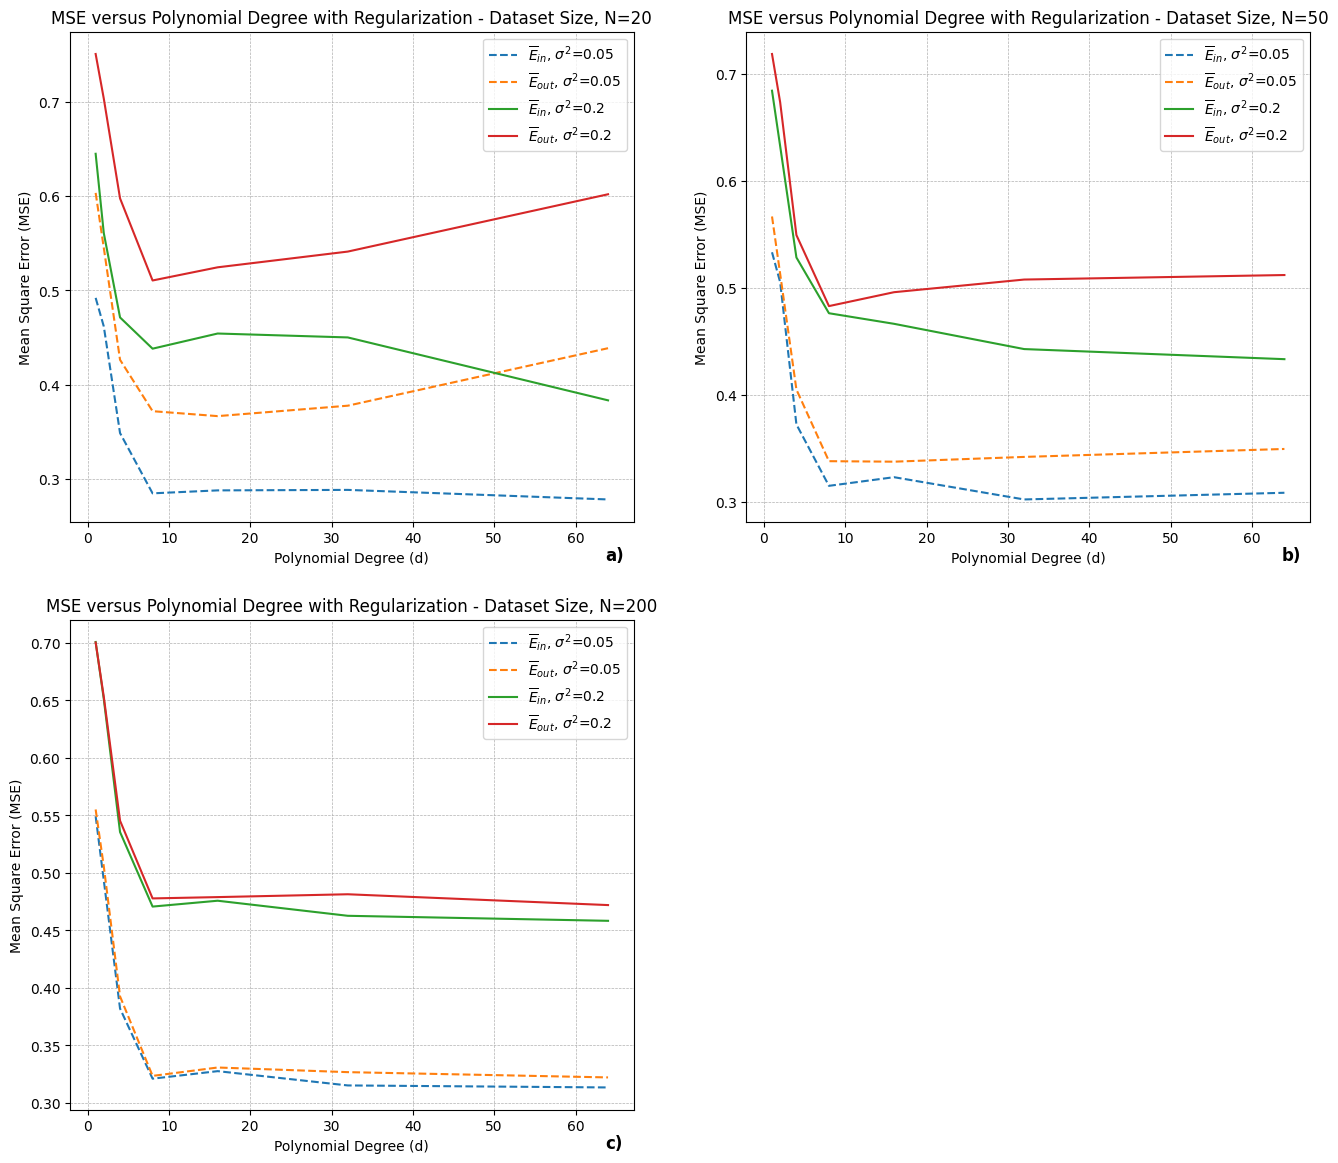

In [34]:
# Plot graphs for fixed values of N with regularization
# Reminder: Output tuples have format - (N, d, Ein_bar, Eout_bar)
current_subplot = 1
plt.figure(figsize=(16, 14))
for N_value in N_array_mapping:
    # Filter the list of result tuples to only return was the first element of the tuple, N, equals the chosed N value
    results_N_10_zeropoint5 = list(filter(lambda output_tuple: output_tuple[0] == N_value, output_variance_zeropoint5_reg))
    results_N_10_point2 = list(filter(lambda output_tuple: output_tuple[0] == N_value, output_variance_point2_reg))

    d_array = list(zip(*results_N_10_zeropoint5))[1]
    E_in_zeropoint5 = list(zip(*results_N_10_zeropoint5))[2]
    E_out_zeropoint5 = list(zip(*results_N_10_zeropoint5))[3]
    E_in_point2 = list(zip(*results_N_10_point2))[2]
    E_out_point2 = list(zip(*results_N_10_point2))[3]

    print(f"N={N_value}:", E_in_zeropoint5)

    # Add this subplot to the figure of all graphs
    axs = plt.subplot(2,2,current_subplot)
    plt.plot(d_array, E_in_zeropoint5, label=f"{e_hat}{in_sub}, $\sigma^2$=0.05",linestyle='--')
    plt.plot(d_array, E_out_zeropoint5, label=f"{e_hat}{out_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(d_array, E_in_point2, label=f"{e_hat}{in_sub}, $\sigma^2$=0.2")
    plt.plot(d_array, E_out_point2, label=f"{e_hat}{out_sub}, $\sigma^2$=0.2")
    plt.xlabel("Polynomial Degree (d)")
    plt.ylabel("Mean Square Error (MSE)")
    plt.title(f"MSE versus Polynomial Degree with Regularization - Dataset Size, N={N_value}")
    plt.legend(fontsize=10)
    plt.grid(linewidth=0.5, linestyle='--')
    axs.text(0.95, -0.05, labels[current_subplot-1], transform=axs.transAxes, fontsize=12, weight='bold', va='top')
    current_subplot += 1
    
plt.show

N=200: (0.07461376326296319, 0.3154374685638892, 0.41546507595998944, 0.46188421532048624, 0.5055061156290956, 0.48520241751951276, 0.4936093254335402)
N=200: (0.049234666850336124, 0.18369984084794094, 0.2331076375782848, 0.2880145819352211, 0.3233925701623553, 0.320308458289648, 0.3276812593673481)
N=200: (0.08467533005998322, 0.2213537540430034, 0.2738620125712669, 0.28853273517493366, 0.30261002114308105, 0.31711690287257277, 0.3152607074360574)


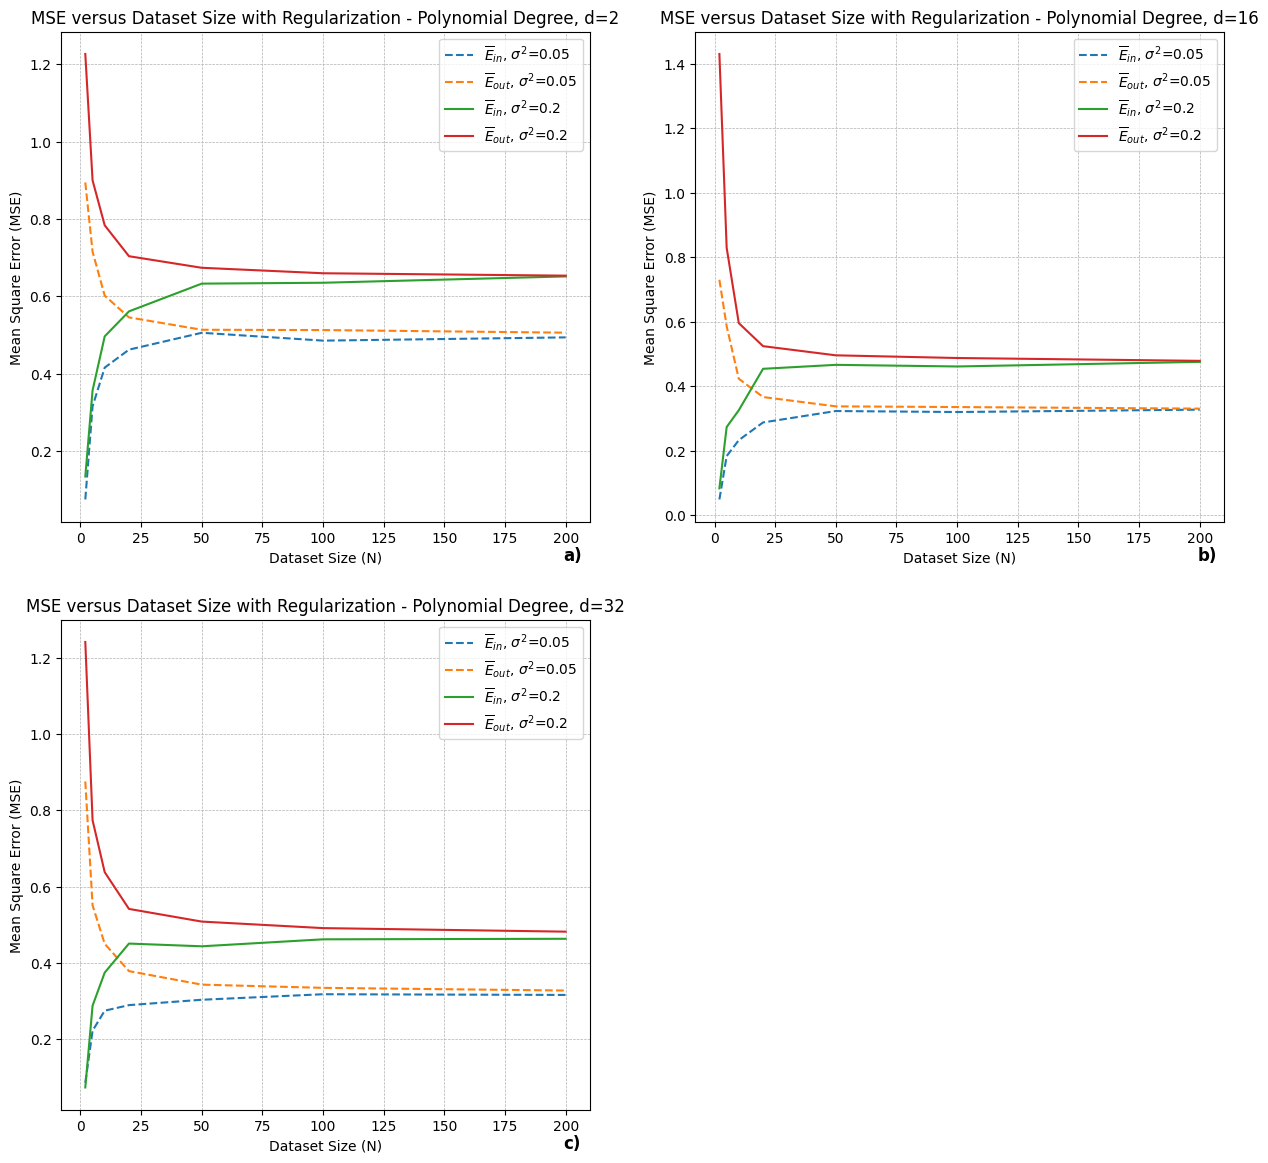

In [35]:
# Plot graphs for fixed values of d with regularization
# Reminder for me: Output tuples have format - (N, d, Ein_bar, Eout_bar)
current_subplot = 1
plt.figure(figsize=(15, 14))
for d_value in d_array_mapping:
    # Filter the list of result tuples to only return was the first element of the tuple, N, equals the chosed N value
    results_N_10_zeropoint5 = list(filter(lambda output_tuple: output_tuple[1] == d_value, output_variance_zeropoint5_reg))
    results_N_10_point2 = list(filter(lambda output_tuple: output_tuple[1] == d_value, output_variance_point2_reg))

    N_array = list(zip(*results_N_10_zeropoint5))[0]
    E_in_zeropoint5 = list(zip(*results_N_10_zeropoint5))[2]
    E_out_zeropoint5 = list(zip(*results_N_10_zeropoint5))[3]
    E_in_point2 = list(zip(*results_N_10_point2))[2]
    E_out_point2 = list(zip(*results_N_10_point2))[3]

    print(f"N={N_value}:", E_in_zeropoint5)
    
    # Add this subplot to the figure of all graphs
    axs = plt.subplot(2,2,current_subplot)
    plt.plot(N_array, E_in_zeropoint5, label=f"{e_hat}{in_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(N_array, E_out_zeropoint5, label=f"{e_hat}{out_sub}, $\sigma^2$=0.05", linestyle='--')
    plt.plot(N_array, E_in_point2, label=f"{e_hat}{in_sub}, $\sigma^2$=0.2")
    plt.plot(N_array, E_out_point2, label=f"{e_hat}{out_sub}, $\sigma^2$=0.2")
    plt.xlabel("Dataset Size (N)")
    plt.ylabel("Mean Square Error (MSE)")
    plt.title(f"MSE versus Dataset Size with Regularization - Polynomial Degree, d={d_value}")
    plt.legend(fontsize=10)
    plt.grid(linewidth=0.5, linestyle='--')
    axs.text(0.95, -0.05, labels[current_subplot-1], transform=axs.transAxes, fontsize=12, weight='bold', va='top')
    
    current_subplot += 1